In [1]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set(rc={'figure.figsize': (18, 6)})

### Сбор и обработка данных: Как вы собираете и обрабатываете данные, которые будут использоваться для создания вашей истории. Вы должны указать источники данных и методы обработки.

Для создания визуальной истории о кинопроизводстве использованы следующие библиотеки и методы:

Сбор данных:

requests: использована для выполнения HTTP-запросов и получения HTML-страниц с сайта.
BeautifulSoup: использована для парсинга HTML и извлечения необходимых данных, таких как название фильмов, жанры, рейтинги.

Обработка данных:

pandas: использована для организации данных в структуру DataFrame для удобного анализа и манипуляции. Данные были очищены, отфильтрованы и подготовлены для анализа.
Анализ данных:

Корреляция: вычислена корреляция между различными переменными, такими как жанры фильмов и их рейтинги, чтобы выявить возможные взаимосвязи.
Регрессионный анализ: проведен регрессионный анализ для определения влияния года выпуска фильма на его рейтинг.

Визуализация данных:

seaborn: использована для создания визуализаций данных, таких как графики распределения, регрессионные графики.

Источник данных:

Данные были собраны с сайта https://www.film.ru/a-z/movies/russia.

In [2]:
url = "https://www.film.ru/a-z/movies/russia"

In [3]:
r = requests.get(url)
soup = BeautifulSoup(r.text, 'lxml')

In [4]:
# Название
name = soup.find('div', class_='redesign_afisha_movie') \
                    .find('a', class_='redesign_afisha_movie_main_title').text.strip()
name

'Свет'

In [5]:
# Оригинальное название
year = soup.find('div', class_='redesign_afisha_movie') \
                     .find('div', class_='redesign_afisha_movie_main_subtitle').text.split('\n')[1].strip()[:4]
year

'2023'

In [6]:
# Жанр
genre = soup.find('div', class_='redesign_afisha_movie') \
            .find('div', class_='redesign_afisha_movie_main_info').text.split('/')[0].strip()
genre

'драма'

In [7]:
# Страна
country = soup.find('div', class_='redesign_afisha_movie') \
            .find('div', class_='redesign_afisha_movie_main_info').text.split('/')[1].strip()
country

'Россия'

In [8]:
# Рейтинг IMDb
rate_IMDb = soup.find('div', class_='redesign_afisha_movie') \
            .find('div', class_='redesign_afisha_movie_main_rating').text.split('\n')

for line in rate_IMDb:
    if 'IMDb:' in line:
        # Извлекаем следующую строку, содержащую рейтинг
        rating_index = rate_IMDb.index(line) + 1
        rating = rate_IMDb[rating_index].strip()
        break
print(rating)

7.3


In [9]:
# Извлечение данных для всех фильмов

films = soup.findAll('div', class_='redesign_afisha_movie')

data=[]

for film in films:
    name = film.find('a', class_='redesign_afisha_movie_main_title').text.strip()
    year = film.find('div', class_='redesign_afisha_movie_main_subtitle').text.split('\n')[1].strip()[:4]
    genre = film.find('div', class_='redesign_afisha_movie_main_info').text.split('/')[0].strip()
    country = film.find('div', class_='redesign_afisha_movie_main_info').text.split('/')[1].strip()
    rate_IMDb = film.find('div', class_='redesign_afisha_movie_main_rating').text.split('\n')

    for line in rate_IMDb:
        if 'IMDb:' in line:
            rating_index = rate_IMDb.index(line) + 1
            rating = rate_IMDb[rating_index].strip()
            break
    
    data.append([name, year, genre, country, rating])
    

In [10]:
header = ['name', 'year', 'genre', 'country', 'rate_IMDb']
df = pd.DataFrame(data, columns=header)
df.year = df.year.apply(lambda x: x[:4])
df.head()
df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype('int')
df.head()

,name,year,genre,country,rate_IMDb
0,Свет,2023,драма,Россия,7.3
1,Бери да помни,2023,комедия,Россия,6.9
2,Кочегар,2010,детектив,Россия,6.6
3,Нелюбовь,0,драма,Россия,7.6
4,Аритмия,2017,драма,Россия,7.4


In [11]:
df['rate_IMDb'] = pd.to_numeric(df['rate_IMDb'], errors='coerce')

In [12]:
# Группировка фильмов по жанрам
df_genre = df.groupby('genre', as_index=False)['name'].count().sort_values('name', ascending=False)
df_genre

,genre,name
3,драма,23
4,комедия,3
1,боевик,2
0,биографический,1
2,детектив,1


Text(0.5, 1.0, 'Распределение фильмов по жанрам')

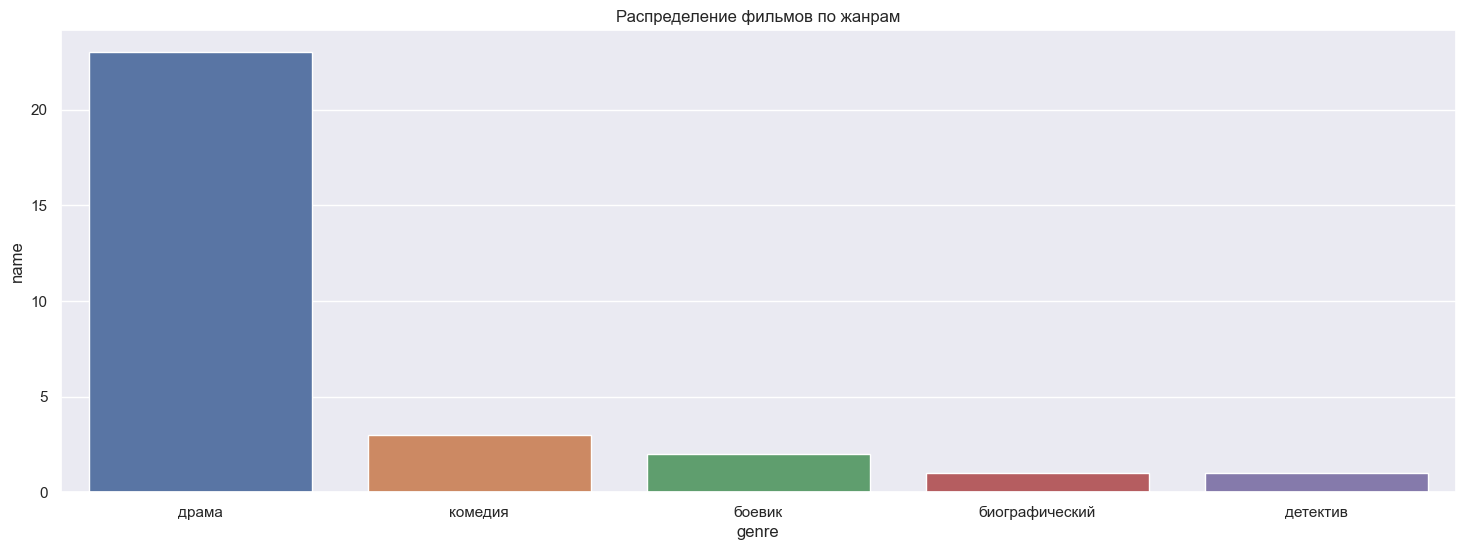

In [13]:
sns.barplot(x='genre', y='name', data=df_genre)
plt.title('Распределение фильмов по жанрам')

In [108]:
# Средний рейтинг фильмов по жанрам
df_rating = round(df.groupby('genre', as_index=False)['rate_IMDb'].mean(), 2).sort_values('rate_IMDb', ascending=False)
df_rating

,genre,rate_IMDb
0,биографический,7.40
1,боевик,7.30
4,комедия,7.03
3,драма,6.95
2,детектив,6.60


Text(0.5, 1.0, 'Распределение жанров по рейтингу')

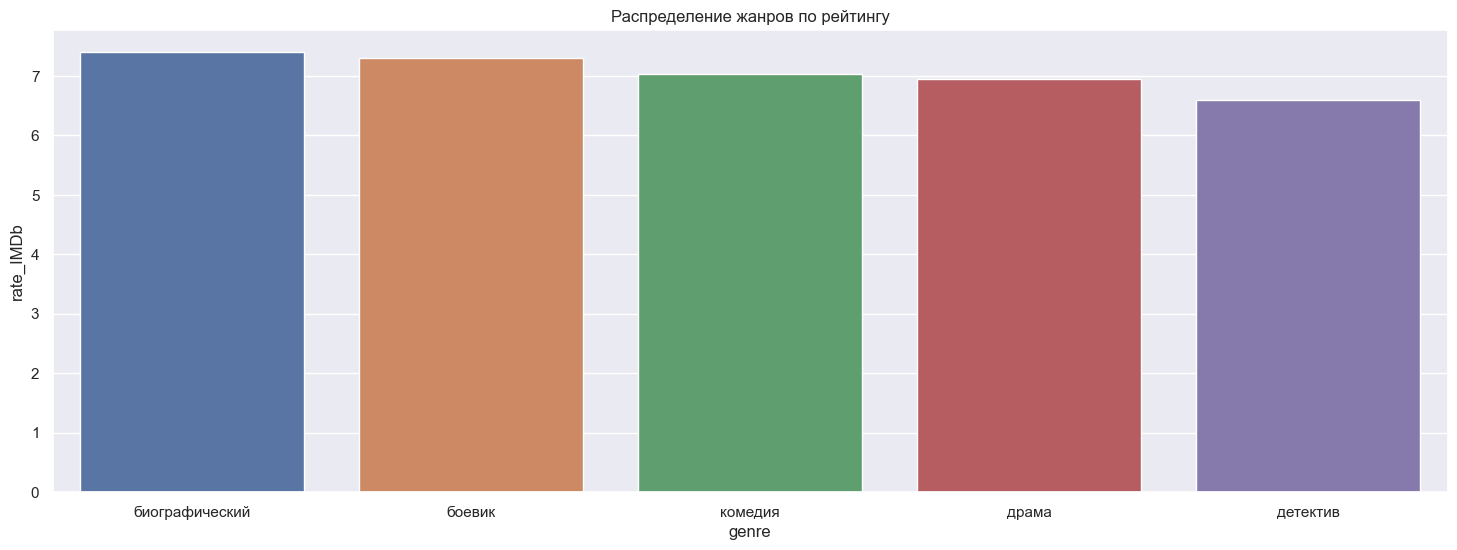

In [109]:
sns.barplot(x='genre', y='rate_IMDb', data=df_rating)
plt.title('Распределение жанров по рейтингу')

In [128]:
# Посмотрим на корреляцию
df.corr()

C:\Users\Alla\AppData\Local\Temp\ipykernel_7532\582793284.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,year,rate_IMDb
year,1.000000,-0.220962
rate_IMDb,-0.220962,1.000000


Значение -0.220962 указывает на слабую отрицательную корреляцию между годом и рейтингом IMDb. Это означает, что по мере увеличения года рейтинг IMDb имеет тенденцию к небольшому снижению, но связь очень слабая.

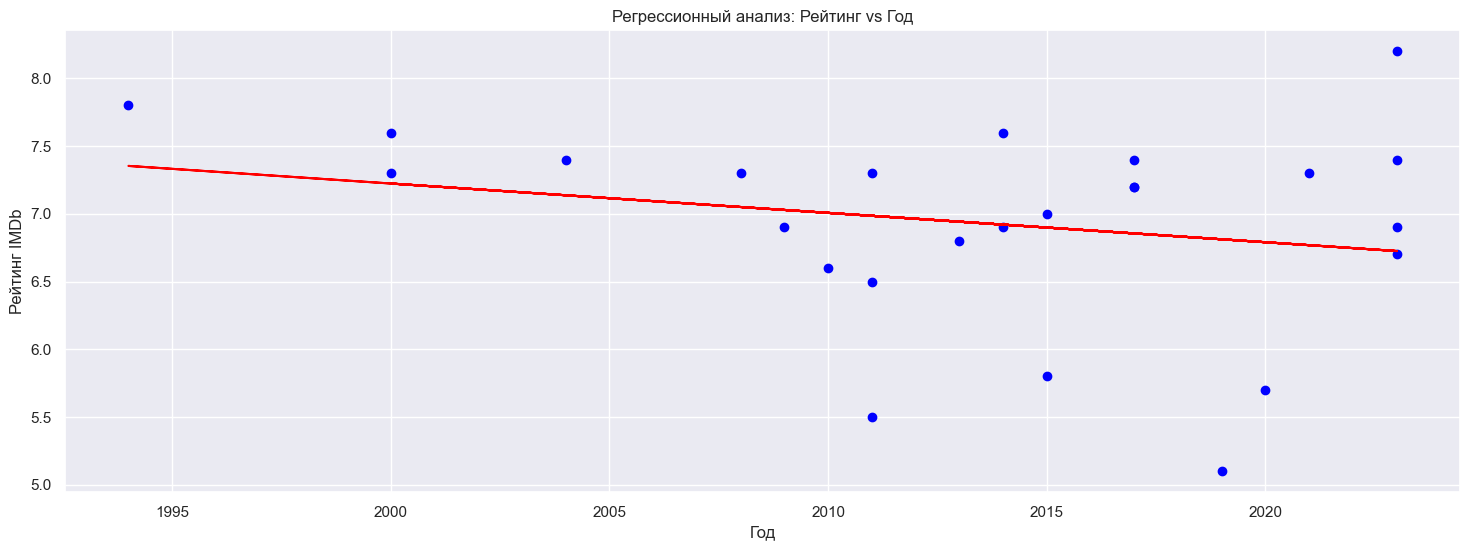

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.250
Date:                Fri, 28 Jun 2024   Prob (F-statistic):              0.275
Time:                        12:55:32   Log-Likelihood:                -26.807
No. Observations:                  25   AIC:                             57.61
Df Residuals:                      23   BIC:                             60.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5563     39.015      1.296      0.2

In [142]:
# Регрессионная модель

df = df[df['year'] != 0]

X = df['year'].values.reshape(-1, 1) 
y = df['rate_IMDb'].values

# Создание модели линейной регрессии
model = LinearRegression()
model.fit(X, y)

# Предсказание
y_pred = model.predict(X)

# Построение графика
plt.scatter(X, y, color='blue')
plt.plot(X, y_pred, color='red')
plt.xlabel('Год')
plt.ylabel('Рейтинг IMDb')
plt.title('Регрессионный анализ: Рейтинг vs Год')
plt.show()

# Использование statsmodels для получения более детальной информации о модели
X = sm.add_constant(X)  # Добавление константы
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Вывод результатов модели
print(model.summary())

Связь между годом выпуска фильма и его рейтингом слабая и не статистически значимая. 

Выводы:
Взаимосвязь между количеством фильмов и рейтингом:

Драма: несмотря на то, что драма является доминирующим жанром по количеству фильмов (23), средний рейтинг IMDb для драматических фильмов составляет 6.95, что ниже, чем у других жанров.
Комедия представлена 3 фильмами с средним рейтингом 7.03, что выше, чем у драматических фильмов, но комедийных фильмов меньше.
Боевик и Биографический: эти жанры имеют высокие рейтинги (7.30 и 7.40 соответственно), но небольшое количество фильмов (2 и 1 соответственно).
Детектив: имеет самый низкий средний рейтинг (6.60) и представлен одним фильмом.

Рекомендации для киностудий и продюсеров:

Увеличение производства в жанрах с высоким рейтингом: стоит рассмотреть увеличение количества фильмов в жанрах "Биографический" и "Боевик", так как они имеют высокие рейтинги.
Анализ качества драматических фильмов: оскольку драмы имеют относительно низкий средний рейтинг, необходимо провести анализ причин и работать над улучшением качества сценариев, актерской игры и режиссуры в этом жанре.
Поддержка и развитие комедийных фильмов: комедии показывают хороший рейтинг при небольшом количестве фильмов, что может свидетельствовать о потенциале для роста в этом жанре.

Маркетинговые стратегии:

Акцент на продвижении высокорейтинговых фильмов: в маркетинговых кампаниях стоит делать упор на фильмы с высокими рейтингами, чтобы привлечь больше зрителей.
Создание нишевых рекламных кампаний: для жанров с меньшим количеством фильмов, но высокими рейтингами, можно создать специализированные рекламные кампании для увеличения их популярности.
Дополнительные исследования:

Анализ аудитории: исследование предпочтений и отзывов зрителей по жанрам для более точного понимания их вкусов.
Сравнительный анализ с предыдущими годами: сравнение данных по жанрам и рейтингам с предыдущими периодами для выявления трендов и изменений в предпочтениях зрителей.